# Validation Evaluation Pipeline Notebook

This notebook implements the plan for building a validation and evaluation pipeline for comparing AI-based evaluators against human evaluations. It follows the detailed plan to load data, define distance metrics, compute inter-rater reliability, incorporate multiple AI evaluators, and produce comprehensive visualizations.

**Notebook Structure**:
1. Imports and Setup
2. Load Framework and Human Evaluations
3. Helper Functions: Mapping and Distance Computation
4. Model Calling Helper
5. Compute Inter-Rater Reliability (Cohen's Kappa)
6. Manual Configuration: Models & Dataset Selection
7. Prepare Tasks for Debugging (skip completed tasks)
8. Evaluation Execution (progressive saving every 5 evaluations)
9. Visualizations
10. Save Intermediate Results

*Note: This notebook assumes that the evaluation framework JSON (`Teach_1.json`) and the cleaned transcripts CSV (`peru_cleaned_transcripts.csv`) are available in the working directory. Intermediate results will be saved progressively to the `model_evaluation_data` directory.*


## Root Cause Analysis

Using `ipywidgets` and registering `run_evaluation` via `run_button.on_click` executes the evaluation in an asynchronous callback context. In Jupyter, output from widget callbacks does not appear in the original code cell output area, causing debugging logs and `print` statements to be hidden. To fix this, we remove widgets entirely and invoke the evaluation functions directly within cells, ensuring all logs and prints are displayed inline.


In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import json
import os
import sys
import logging
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import inspect
from typing import Dict, Any, Optional, List, Tuple

# Set random seed for reproducibility
np.random.seed(42)

# Detect Google Colab environment
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print(f"Libraries imported successfully.  IN_COLAB = {IN_COLAB}")

# Utility: download file from Google Drive if running in Colab
if IN_COLAB:
    try:
        import gdown
    except ImportError:
        # Install gdown if missing
        print("🔄 Installing gdown for Drive downloads...")
        !pip install --quiet gdown
        import gdown

    def download_from_gdrive(url: str) -> str:
        """
        Download a file from a Google Drive link to the local environment.
        Returns the local file path.
        """
        print(f"🔍 Downloading audio file from Google Drive: {url}")
        # Let gdown handle the link parsing
        local_filename = os.path.basename(url.split('?')[0])
        if not local_filename:
            local_filename = 'audio_file'
        try:
            gdown.download(url, local_filename, quiet=False)
            print(f"✅ Downloaded audio to {local_filename}")
            return local_filename
        except Exception as e:
            print(f"❌ Error downloading audio: {e}")
            raise
else:
    def download_from_gdrive(url: str) -> str:
        """
        Dummy stub when not in Colab to prevent accidental downloads.
        """
        raise RuntimeError(
            "Multimodal evaluation requires Google Colab environment for audio download."
        )




Libraries imported successfully.  IN_COLAB = False


In [2]:
# 2. Load Framework and Human Evaluations
def load_human_evaluations(cleaned_csv_path: str, framework_json_path: str) -> pd.DataFrame:
    """
    Load cleaned transcripts and human evaluation columns.
    Returns a DataFrame with columns ['base_id','clip_number',<each human component name>].
    """
    # Read the cleaned transcripts CSV
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    
    # The actual evaluation columns from the CSV
    evaluation_columns = [
        'Teacher provides learning activity - 1st Snapshot',
        'Students are on task - 1st Snapshot',
        'Teacher provides learning activity - 2nd Snapshot',
        'Students are on task - 2nd Snapshot',
        'Teacher provides learning activity - 3rd Snapshot',
        'Students are on task - 3rd Snapshot',
        'Supportive Learning Environment',
        'The teacher treats all students respectfully',
        'The teacher uses positive language',
        'The teacher responds to students needs',
        'The teacher does not exhibit gender bias',
        'Positive Behavioral Expectations',
        'The teacher sets clear behavioral expectations',
        'The teacher acknowledges positive student behavior',
        'The teacher redirects misbehavior',
        'Lesson Facilitation',
        'The teacher explicitly articulates learning objectives',
        'The teacher\'s explanation of content is clear',
        'The teacher makes connections in the lesson',
        'The teacher models by enacting or thinking aloud',
        'Checks for understanding',
        'The teacher uses questions',
        'The teacher uses prompts',
        'The teacher monitors most students',
        'The teacher adjusts teaching to the level of students',
        'Feedback',
        'The teacher provides specific comments for misunderstandings',
        'The teacher provides specific comments for successes',
        'Critical Thinking',
        'The teacher asks open-ended questions',
        'The teacher provides thinking tasks',
        'Students ask open-ended questions or perform thinking tasks',
        'Autonomy',
        'The teacher provides students with choices',
        'The teacher provides students with opportunities to take meaningful roles',
        'Students volunteer to participate in the classroom',
        'Perseverance',
        'The teacher acknowledges students\' efforts',
        'The teacher has a positive attitude towards students\' challenges',
        'The teacher encourages goal-setting',
        'Social & Collaborative Skills',
        'The teacher promotes students\' collaboration',
        'The teacher promotes students\' interpersonal skills',
    ]

    # Extract base_id and clip_number from School_Clip
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1': 'first', '2': 'last'})

    # Identify which evaluation columns actually exist
    present = [col for col in evaluation_columns if col in df.columns]
    missing = [col for col in evaluation_columns if col not in df.columns]
    if missing:
        print(f"⚠️ Missing human evaluation columns: {missing}")
    
    print(f"✅ Found {len(present)} evaluation columns in the dataset")

    # Return only base_id, clip_number, and the human-scored columns
    return df[['base_id', 'clip_number'] + present]


In [3]:
# 3. Helper Functions: Mapping and Distance Computation
def alpha_to_numeric(x: Any) -> Optional[float]:
    """
    Convert string labels to numeric:
    - 'Y'/'y'/'Yes'/'1' -> 1.0
    - 'N'/'n'/'No'/'0'  -> 0.0
    - 'N/A' or empty  -> np.nan
    - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
    - Numeric strings convertible to float -> float(x)
    - Otherwise -> np.nan
    """
    if x is None:
        return np.nan
    x_str = str(x).strip()
    if x_str in {"Y", "y", "Yes", "1"}:
        return 1.0
    if x_str in {"N", "n", "No", "0"}:
        return 0.0
    if x_str in {"N/A", "", "NA", "na", "nan"}:
        return np.nan
    if x_str in {"L", "M", "H"}:
        return {"L": 1.0, "M": 2.0, "H": 3.0}[x_str]
    # Try converting directly to float for numeric (1-5 scale)
    try:
        return float(x_str)
    except ValueError:
        return np.nan

def component_distance(human_score: Any, ai_score: Any, score_type: str) -> float:
    """
    Compute normalized distance between human_score and ai_score based on score_type.
    score_type is one of: 'YN', 'LMH', 'NUM' (for 1-5), where 'N/A' handling is builtin.
    Returns a float in [0,1].
    """
    human_num = alpha_to_numeric(human_score)
    ai_num = alpha_to_numeric(ai_score)
    
    if math.isnan(human_num) and math.isnan(ai_num):
        return 0.0
    if math.isnan(human_num) ^ math.isnan(ai_num):
        return 1.0
    if score_type == 'YN':
        d_max = 1.0
    elif score_type == 'LMH':
        d_max = 2.0
    elif score_type == 'NUM':
        d_max = 4.0
    else:
        d_max = 1.0
    raw_diff = abs(human_num - ai_num)
    normalized_diff = raw_diff / d_max
    return min(max(normalized_diff, 0.0), 1.0)

def compute_distances_for_item(human_row: pd.Series,
                               ai_row: pd.Series,
                               framework: Dict[str, Any]) -> Tuple[Dict[str, float], float]:
    domain_distances: Dict[str, float] = {}
    domain_weights_sum = 0.0
    overall_numerator = 0.0
    for domain in framework['structure']['domains']:
        domain_id = str(domain['id'])
        domain_weight = float(domain.get('weight', 1.0))
        domain_numerator = 0.0
        domain_weight_sum = 0.0
        for comp in domain['components']:
            comp_name = comp['name']
            comp_weight = float(comp.get('weight', 1.0))
            score_list = comp.get('scoreList', [])
            score_type = 'NUM'
            if set(score_list) <= {"Y","N","N/A"}:
                score_type = 'YN'
            elif set(score_list) <= {"L","M","H","N/A"}:
                score_type = 'LMH'
            human_score = human_row.get(comp_name, None)
            ai_score = ai_row.get(comp_name, None)
            d_c = component_distance(human_score, ai_score, score_type)
            domain_numerator += comp_weight * d_c
            domain_weight_sum += comp_weight
        D_domain = (domain_numerator / domain_weight_sum) if domain_weight_sum > 0 else 0.0
        domain_distances[domain_id] = D_domain
        overall_numerator += domain_weight * D_domain
        domain_weights_sum += domain_weight
    overall_distance = (overall_numerator / domain_weights_sum) if domain_weights_sum > 0 else 0.0
    return domain_distances, overall_distance


In [4]:
def call_model(
    evaluator_cls: type,
    framework: Dict[str, Any],
    transcript_text: str,
    audio_file_path: Optional[str] = None,
    enable_throttling: bool = False
) -> Dict[str, Any]:
    try:
        print(f"🔍 DEBUG: Creating evaluator with throttling={enable_throttling}")
        evaluator = evaluator_cls(framework, enable_throttling=enable_throttling)

        local_audio_path = None
        # Step 1: Download (if needed)
        if audio_file_path:
            if not IN_COLAB:
                error_msg = "Multimodal evaluation requires Google Colab environment. Skipping evaluation."
                print(f"❌ {error_msg}")
                return {'domains': {}, 'summary': '', 'error': error_msg}
            try:
                local_audio_path = download_from_gdrive(audio_file_path)
            except Exception as e:
                error_msg = f"Audio download failed: {e}"
                print(f"❌ {error_msg}")
                return {'domains': {}, 'summary': '', 'error': error_msg}

        try:
            print(f"🔍 DEBUG: Calling evaluator.evaluate() with text length: {len(transcript_text)}")
            # Step 2: Invoke evaluator
            sig = inspect.signature(evaluator.evaluate)
            if 'audio_file_path' in sig.parameters and local_audio_path:
                result = evaluator.evaluate(transcript_text, audio_file_path=local_audio_path)
            elif 'audio_file' in sig.parameters and local_audio_path:
                result = evaluator.evaluate(transcript_text, audio_file=local_audio_path)
            else:
                result = evaluator.evaluate(transcript_text)

            print(f"🔍 DEBUG: Evaluator returned: {type(result)}")
            
            # Normalize returned structure
            if isinstance(result, dict):
                if 'success' in result:
                    if not result['success']:
                        error_msg = f"Evaluator returned failure: {result.get('error', 'Unknown error')}"
                        print(f"❌ Error in call_model: {error_msg}")
                        return {'domains': {}, 'summary': '', 'error': result.get('error', 'Unknown error')}
                    eval_result = result.get('evaluation', {})
                else:
                    eval_result = result
            else:
                error_msg = f"Unexpected evaluator output type: {type(result)}"
                print(f"❌ Error in call_model: {error_msg}")
                return {'domains': {}, 'summary': '', 'error': error_msg}

            if 'domains' not in eval_result:
                print("❌ Error in call_model: Missing 'domains' in evaluator output")
                eval_result['domains'] = {}

            print(f"🔍 DEBUG: Successfully processed evaluation with {len(eval_result.get('domains', {}))} domains")
            return eval_result

        except Exception as eval_exc:
            error_msg = f"Exception in evaluator.evaluate(): {type(eval_exc).__name__}: {eval_exc}"
            print(f"🔍 DEBUG: {error_msg}")
            return {'domains': {}, 'summary': '', 'error': str(eval_exc)}

    except Exception as setup_exc:
        error_msg = f"Exception in call_model setup: {type(setup_exc).__name__}: {setup_exc}"
        print(f"🔍 DEBUG: {error_msg}")
        return {'domains': {}, 'summary': '', 'error': str(setup_exc)}
    
    finally:
        # Step 3: Cleanup downloaded audio
        if local_audio_path and os.path.exists(local_audio_path):
            try:
                os.remove(local_audio_path)
                print(f"🧹 Removed temporary audio file: {local_audio_path}")
            except Exception as cleanup_err:
                print(f"⚠️ Failed to remove temporary audio file {local_audio_path}: {cleanup_err}")


In [5]:
# 5. Compute Inter-Rater Reliability (Cohen's Kappa)
def encode_for_kappa(series: pd.Series, score_list: List[Any]) -> pd.Series:
    mapping = {str(lbl): idx for idx, lbl in enumerate(score_list)}
    na_idx = mapping.get('N/A')
    def map_val(x):
        x_str = str(x)
        if x_str in mapping:
            return mapping[x_str]
        return na_idx if na_idx is not None else np.nan
    return series.map(map_val)

def compute_component_kappa(human_series: pd.Series,
                            ai_series: pd.Series,
                            score_list: List[Any],
                            weight: Optional[str] = None
                           ) -> float:
    h_enc = encode_for_kappa(human_series, score_list)
    a_enc = encode_for_kappa(ai_series, score_list)
    mask = ~(h_enc.isna() | a_enc.isna())
    if mask.sum() == 0:
        return np.nan
    if weight is None:
        numeric_labels = all(str(lbl).isdigit() for lbl in score_list) and len(score_list) > 2
        if any(lbl in ['L','M','H'] for lbl in score_list) or numeric_labels:
            weight = 'quadratic'
    return cohen_kappa_score(h_enc[mask], a_enc[mask], weights=weight)


In [6]:
# 6. Manual Configuration: Models & Dataset Selection
import sys
sys.path.append('/Users/mkrasnow/Desktop/montesa')

from new.models.control.control import BaseModelEvaluator

# Add other evaluator imports as needed
available_models = {
    '0-TEST-Control': BaseModelEvaluator
}

# Manually configure which models to run
MODEL_LIST = ['0-TEST-Control']  # e.g., ['BaseEvaluator', 'ChainEvaluator']

# Manually configure dataset split: 'Train/Validation' or 'Test'
# SPLIT = 'Train/Validation'
SPLIT = 'Test'
# If using Test split, set TEST_CONFIRM to True to allow evaluation

TEST_CONFIRM = True

ENABLE_THROTTLING = True
MAX_WORKERS_THROTTLED = 1  # Single worker to avoid conflicts
MAX_WORKERS_NORMAL = 4     # Multiple workers when not throttling

print(f"Configured models: {MODEL_LIST}")
print(f"Configured split: {SPLIT} (Test confirm: {TEST_CONFIRM})")
print(f"Rate limiting enabled: {ENABLE_THROTTLING}")
if ENABLE_THROTTLING:
    print("⚠️ Throttling enabled: Limited to 3 API calls per minute with 1 worker")
else:
    print(f"🚀 Throttling disabled: Using {MAX_WORKERS_NORMAL} workers for parallel execution")


Configured models: ['0-TEST-Control']
Configured split: Test (Test confirm: True)
Rate limiting enabled: True
⚠️ Throttling enabled: Limited to 3 API calls per minute with 1 worker


In [7]:
# 7. Prepare Tasks for Debugging (skip already completed)
# Load framework and transcripts
FRAMEWORK_PATH = '/Users/mkrasnow/Desktop/montesa/new/models/_context/no_rubric_Teach_1.json'
TRANSCRIPTS_PATH = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'
OUTDIR = 'model_evaluation_data'
os.makedirs(OUTDIR, exist_ok=True)

framework = json.load(open(FRAMEWORK_PATH))
df_all = pd.read_csv(TRANSCRIPTS_PATH, dtype=str)
df_all['base_id'] = df_all['School_Clip'].str.extract(r"(\d{6,7})", expand=False)
df_all['clip_number'] = (
    df_all['School_Clip']
    .str.extract(r'Clip\s*([12])', expand=False)
    .map({'1': 'first', '2': 'last'})
)

# Determine completed tasks by reading existing evaluation files
completed = set()
for model_name in MODEL_LIST:
    eval_file = f"{OUTDIR}/{model_name}_evaluations.csv"
    if os.path.exists(eval_file):
        df_done = pd.read_csv(eval_file, dtype=str)
        for _, r in df_done.iterrows():
            completed.add((r.get('base_id'), r.get('clip_number'), model_name))

# Filter based on manual split configuration
if SPLIT == 'Test' and not TEST_CONFIRM:
    print('⚠️ Cannot prepare tasks: Test set evaluation not confirmed.')
    PREPARED_TASKS = []
else:
    if SPLIT == 'Test':
        df_split = df_all[df_all['split'] == 'test'].copy()
    else:
        df_split = df_all[df_all['split'].isin(['train', 'val'])].copy()

    # Build tasks list (row, model_name) skipping completed
    PREPARED_TASKS = []
    for model_name in MODEL_LIST:
        for _, row in df_split.iterrows():
            key = (row['base_id'], row['clip_number'], model_name)
            if key not in completed:
                PREPARED_TASKS.append((row, model_name))

    print(f"🔧 Prepared {len(PREPARED_TASKS)} new tasks for evaluation.")
    for i, (row, model_name) in enumerate(PREPARED_TASKS[:5], start=1):
        print(f"  Task {i}: base_id={row['base_id']}, clip={row['clip_number']}, model={model_name}")


🔧 Prepared 84 new tasks for evaluation.
  Task 1: base_id=256305, clip=first, model=0-TEST-Control
  Task 2: base_id=256305, clip=last, model=0-TEST-Control
  Task 3: base_id=1304765, clip=first, model=0-TEST-Control
  Task 4: base_id=1304765, clip=last, model=0-TEST-Control
  Task 5: base_id=256776, clip=last, model=0-TEST-Control


In [8]:
# 9. Visualizations
import os

def visualize_results(outdir='model_evaluation_data'):
    # Load distance metrics CSV
    distances_path = os.path.join(outdir, 'distance_metrics.csv')
    if not os.path.exists(distances_path):
        print(f"❌ Distance metrics file not found at {distances_path}. Please run evaluation first.")
        return
    distances_df = pd.read_csv(distances_path)
    
    # Load kappa results CSV
    kappa_path = os.path.join(outdir, 'kappa_results.csv')
    if not os.path.exists(kappa_path):
        print(f"❌ Kappa results file not found at {kappa_path}. Please run evaluation first.")
        return
    kappa_df = pd.read_csv(kappa_path)

    # Ensure required columns
    if 'model_name' not in distances_df.columns or 'overall_distance' not in distances_df.columns:
        print("❌ Required columns missing in distances_df.")
        return

    names = distances_df['model_name'].unique().tolist()

    # 1. Boxplot of overall distances per model
    plt.figure(figsize=(8, 6))
    data = [
        distances_df.loc[distances_df['model_name'] == name, 'overall_distance'].dropna()
        for name in names
    ]
    plt.boxplot(data, labels=names)
    plt.title('Overall Distance per Model')
    plt.ylabel('Normalized Distance')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.show()

    # 2. Histograms of overall distances
    plt.figure(figsize=(10, 6))
    for name in names:
        subset = distances_df.loc[distances_df['model_name'] == name, 'overall_distance'].dropna()
        plt.hist(subset, bins=20, alpha=0.5, label=name)
    plt.legend()
    plt.title('Histogram of Overall Distances')
    plt.xlabel('Normalized Distance')
    plt.ylabel('Frequency')
    plt.show()

    # 3. Bar chart of average kappa per model
    if 'model_name' in kappa_df.columns and 'kappa' in kappa_df.columns:
        summary = kappa_df.groupby('model_name')['kappa'].mean().reset_index()
        plt.figure(figsize=(8, 6))
        plt.bar(summary['model_name'], summary['kappa'])
        plt.title("Average Cohen's Kappa per Model")
        plt.ylim(-1, 1)
        plt.xlabel('Model Name')
        plt.ylabel("Cohen's Kappa")
        plt.grid(True, axis='y', alpha=0.3)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("❌ Required columns missing in kappa_df.")

    print("✅ Visualizations complete.")

# 10. Save Intermediate Results
def save_results():
    if 'GLOBAL_DISTANCES_DF' in globals() and 'GLOBAL_KAPPA_DF' in globals():
        GLOBAL_DISTANCES_DF.reset_index().to_csv('evaluation_distances.csv', index=False)
        GLOBAL_KAPPA_DF.to_csv('evaluation_kappa.csv', index=False)
        print('Results saved to evaluation_distances.csv and evaluation_kappa.csv')
    else:
        print('No results to save. Run evaluation first.')


Starting evaluation...
✅ Found 43 evaluation columns in the dataset
🐌 Rate limiting enabled: Using 1 worker(s) with 3 API calls per minute limit
📊 Estimated time for 84 tasks: 112.0 minutes
   (Each evaluation makes ~4 API calls: 4 domain batches )
🔍 DEBUG: Creating evaluator with throttling=True
🔍 DEBUG: Calling evaluator.evaluate() with text length: 136
🔍 DEBUG: Starting evaluation - text length: 136 chars
🔍 DEBUG: Found 4 domains in framework
🔍 DEBUG: Starting batch evaluations for 4 domains
🔍 DEBUG: Scheduling batch evaluation for domain: Time on Task
🔍 DEBUG: Starting batch evaluation for domain: Time on Task (6 components)
🔍 DEBUG: Scheduling batch evaluation for domain: Classroom Culture
🔍 DEBUG: Starting batch evaluation for domain: Classroom Culture (9 components)
🔍 DEBUG: Scheduling batch evaluation for domain: Instruction
🔍 DEBUG: Starting batch evaluation for domain: Instruction (16 components)
🔍 DEBUG: Scheduling batch evaluation for domain: Socioemotional Skills
🔍 DEBUG: 

I0000 00:00:1750191492.246742 6531404 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating models:   0%|          | 0/84 [00:00<?, ?it/s]

AI returned invalid score 'N/A' for Students are on task - 2nd Snapshot, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Teacher provides learning activity - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_2 for Students are on task - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_3 for Teacher provides learning activity - 2nd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 2nd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for Students are on task - 2nd Snapshot
🔍 DEBUG: ✅ Successfully parsed component_5 for Teacher provides learning activity - 3rd Snapshot
🔍 DEBUG: ✅ Successfully parsed component_6 for Students are on task - 3rd Snapshot
🔍 DEBUG: Completed batch evaluation for domain: Time on Task - 6 components processed
🔍 DEBUG: Successfully processed 6 components for domain: Time on Task
🔍 DEBUG: Collecting results for domain: Classroom Culture
🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats

AI returned invalid score 'N/A' for The teacher responds to students needs, using default.
AI returned invalid score 'N/A' for The teacher does not exhibit gender bias, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher responds to students needs in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher redirects misbehavio

AI returned invalid score 'N/A' for The teacher monitors most students, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Lesson Facilitation
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher explicitly articulates learning objectives
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher's explanation of content is clear
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher makes connections in the lesson
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher models by enacting or thinking aloud
🔍 DEBUG: ✅ Successfully parsed component_6 for Checks for understanding
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher uses questions
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher uses prompts
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher monitors most students in Instruction, using default
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher monitors most students
🔍 DEBUG: ✅ Successfully parsed component_10 for Feedback
🔍 DEBUG: ✅ Successfully parsed component_11 for The teacher provides specific comments for mis

AI returned invalid score 'N/A' for The teacher responds to students needs, using default.
AI returned invalid score 'N/A' for The teacher does not exhibit gender bias, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher responds to students needs in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher redirects misbehavio

AI returned invalid score 'N/A' for The teacher does not exhibit gender bias, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher redirects misbehavior
🔍 DEBUG: Completed batch evaluation for domain: Classroom Culture - 9 components processed
🔍 DEBUG: Successf

AI returned invalid score 'N/A' for The teacher monitors most students, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Lesson Facilitation
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher explicitly articulates learning objectives
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher's explanation of content is clear
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher makes connections in the lesson
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher models by enacting or thinking aloud
🔍 DEBUG: ✅ Successfully parsed component_6 for Checks for understanding
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher uses questions
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher uses prompts
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher monitors most students in Instruction, using default
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher monitors most students
🔍 DEBUG: ✅ Successfully parsed component_10 for Feedback
🔍 DEBUG: ✅ Successfully parsed component_11 for The teacher provides specific comments for mis

AI returned invalid score 'N/A' for The teacher monitors most students, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Lesson Facilitation
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher explicitly articulates learning objectives
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher's explanation of content is clear
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher makes connections in the lesson
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher models by enacting or thinking aloud
🔍 DEBUG: ✅ Successfully parsed component_6 for Checks for understanding
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher uses questions
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher uses prompts
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher monitors most students in Instruction, using default
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher monitors most students
🔍 DEBUG: ✅ Successfully parsed component_10 for Feedback
🔍 DEBUG: ✅ Successfully parsed component_11 for The teacher provides specific comments for mis

AI returned invalid score 'N/A' for Students are on task - 1st Snapshot, using default.
AI returned invalid score 'N/A' for Students are on task - 2nd Snapshot, using default.
AI returned invalid score 'N/A' for Students are on task - 3rd Snapshot, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Teacher provides learning activity - 1st Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 1st Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_2 for Students are on task - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_3 for Teacher provides learning activity - 2nd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 2nd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for Students are on task - 2nd Snapshot
🔍 DEBUG: ✅ Successfully parsed component_5 for Teacher provides learning activity - 3rd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 3rd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_6 for Students are on task - 3rd Snapshot
🔍 DEBUG: Completed batch evaluation for domain: Time on Task - 6 components processed
🔍 DEBUG: Successfully processed 6 components for domain: Time on Tas

AI returned invalid score 'N/A' for The teacher monitors most students, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Lesson Facilitation
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher explicitly articulates learning objectives
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher's explanation of content is clear
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher makes connections in the lesson
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher models by enacting or thinking aloud
🔍 DEBUG: ✅ Successfully parsed component_6 for Checks for understanding
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher uses questions
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher uses prompts
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher monitors most students in Instruction, using default
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher monitors most students
🔍 DEBUG: ✅ Successfully parsed component_10 for Feedback
🔍 DEBUG: ✅ Successfully parsed component_11 for The teacher provides specific comments for mis

AI returned invalid score 'N/A' for The teacher responds to students needs, using default.
AI returned invalid score 'N/A' for The teacher does not exhibit gender bias, using default.
AI returned invalid score 'N/A' for The teacher redirects misbehavior, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher responds to students needs in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher redirects misbehavior in Classro

AI returned invalid score 'N/A' for Students are on task - 1st Snapshot, using default.
AI returned invalid score 'N/A' for Students are on task - 2nd Snapshot, using default.
AI returned invalid score 'N/A' for Students are on task - 3rd Snapshot, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Teacher provides learning activity - 1st Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 1st Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_2 for Students are on task - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_3 for Teacher provides learning activity - 2nd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 2nd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for Students are on task - 2nd Snapshot
🔍 DEBUG: ✅ Successfully parsed component_5 for Teacher provides learning activity - 3rd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 3rd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_6 for Students are on task - 3rd Snapshot
🔍 DEBUG: Completed batch evaluation for domain: Time on Task - 6 components processed
🔍 DEBUG: Successfully processed 6 components for domain: Time on Tas

AI returned invalid score 'N/A' for Students are on task - 2nd Snapshot, using default.
AI returned invalid score 'N/A' for Students are on task - 3rd Snapshot, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Teacher provides learning activity - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_2 for Students are on task - 1st Snapshot
🔍 DEBUG: ✅ Successfully parsed component_3 for Teacher provides learning activity - 2nd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 2nd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for Students are on task - 2nd Snapshot
🔍 DEBUG: ✅ Successfully parsed component_5 for Teacher provides learning activity - 3rd Snapshot
🔍 DEBUG: ❌ Invalid score 'N/A' for Students are on task - 3rd Snapshot in Time on Task, using default
🔍 DEBUG: ✅ Successfully parsed component_6 for Students are on task - 3rd Snapshot
🔍 DEBUG: Completed batch evaluation for domain: Time on Task - 6 components processed
🔍 DEBUG: Successfully processed 6 components for domain: Time on Task
🔍 DEBUG: Collecting results for domain: Classroom Culture
🔍 DEBUG: ✅ Successfully parsed component_1

AI returned invalid score 'None' for Supportive Learning Environment, using default.
AI returned invalid score 'None' for The teacher treats all students respectfully, using default.
AI returned invalid score 'None' for The teacher uses positive language, using default.
AI returned invalid score 'None' for The teacher responds to students needs, using default.
AI returned invalid score 'None' for The teacher does not exhibit gender bias, using default.
AI returned invalid score 'None' for Positive Behavioral Expectations, using default.
AI returned invalid score 'None' for The teacher sets clear behavioral expectations, using default.
AI returned invalid score 'None' for The teacher acknowledges positive student behavior, using default.
AI returned invalid score 'None' for The teacher redirects misbehavior, using default.


🔍 DEBUG: ❌ Invalid score 'None' for Supportive Learning Environment in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ❌ Invalid score 'None' for The teacher treats all students respectfully in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ❌ Invalid score 'None' for The teacher uses positive language in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ❌ Invalid score 'None' for The teacher responds to students needs in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'None' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ❌ Invalid sc

AI returned invalid score 'N/A' for The teacher responds to students needs, using default.
AI returned invalid score 'N/A' for The teacher does not exhibit gender bias, using default.


🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher responds to students needs in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ❌ Invalid score 'N/A' for The teacher does not exhibit gender bias in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher redirects misbehavio

Component key component_1 missing from batch response.
Component key component_2 missing from batch response.
Component key component_3 missing from batch response.
Component key component_4 missing from batch response.
Component key component_5 missing from batch response.
Component key component_6 missing from batch response.
Component key component_7 missing from batch response.
Component key component_8 missing from batch response.
Component key component_9 missing from batch response.
Component key component_10 missing from batch response.
Component key component_11 missing from batch response.
Component key component_12 missing from batch response.
Component key component_13 missing from batch response.
Component key component_14 missing from batch response.
Component key component_15 missing from batch response.
Component key component_16 missing from batch response.


🔍 DEBUG: ❌ JSON decode error in _generate_ai_response_json: Expecting ',' delimiter: line 59 column 132 (char 5298)
🔍 DEBUG: Original response preview: {
  "component_1": {
    "component_id": "Lesson Facilitation",
    "component_name": "Lesson Facilitation",
    "analysis": "The teacher begins by reviewing the previous day's lesson on environmental...
🔍 DEBUG: Cleaned JSON preview: {
  "component_1": {
    "component_id": "Lesson Facilitation",
    "component_name": "Lesson Facilitation",
    "analysis": "The teacher begins by reviewing the previous day's lesson on environmental...
🔍 DEBUG: ❌ Component key component_1 (ID: Lesson Facilitation) missing from AI response in Instruction
🔍 DEBUG: ❌ Component key component_2 (ID: The teacher explicitly articulates learning objectives) missing from AI response in Instruction
🔍 DEBUG: ❌ Component key component_3 (ID: The teacher's explanation of content is clear) missing from AI response in Instruction
🔍 DEBUG: ❌ Component key component_4 (I

AI returned invalid score 'H' for Supportive Learning Environment, using default.
AI returned invalid score 'H' for Positive Behavioral Expectations, using default.


🔍 DEBUG: ❌ Invalid score 'H' for Supportive Learning Environment in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_1 for Supportive Learning Environment
🔍 DEBUG: ✅ Successfully parsed component_2 for The teacher treats all students respectfully
🔍 DEBUG: ✅ Successfully parsed component_3 for The teacher uses positive language
🔍 DEBUG: ✅ Successfully parsed component_4 for The teacher responds to students needs
🔍 DEBUG: ✅ Successfully parsed component_5 for The teacher does not exhibit gender bias
🔍 DEBUG: ❌ Invalid score 'H' for Positive Behavioral Expectations in Classroom Culture, using default
🔍 DEBUG: ✅ Successfully parsed component_6 for Positive Behavioral Expectations
🔍 DEBUG: ✅ Successfully parsed component_7 for The teacher sets clear behavioral expectations
🔍 DEBUG: ✅ Successfully parsed component_8 for The teacher acknowledges positive student behavior
🔍 DEBUG: ✅ Successfully parsed component_9 for The teacher redirects misbehavior
🔍 DEBUG: Complete

/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_63778/3192450539.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=names)


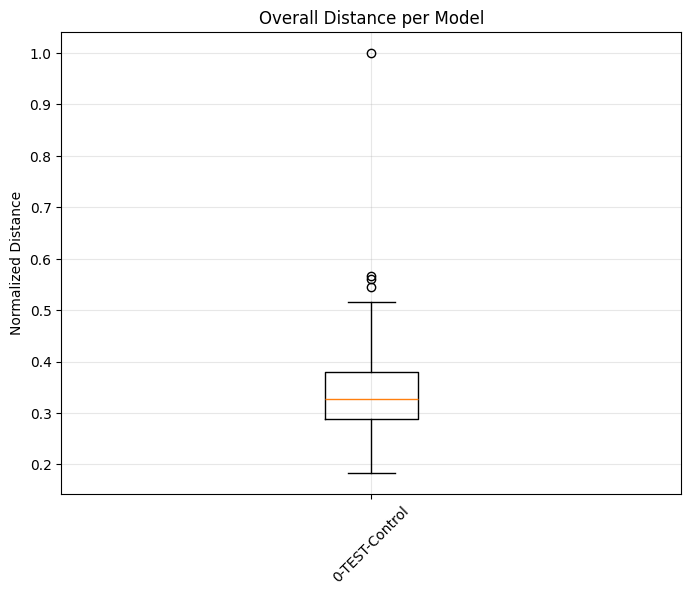

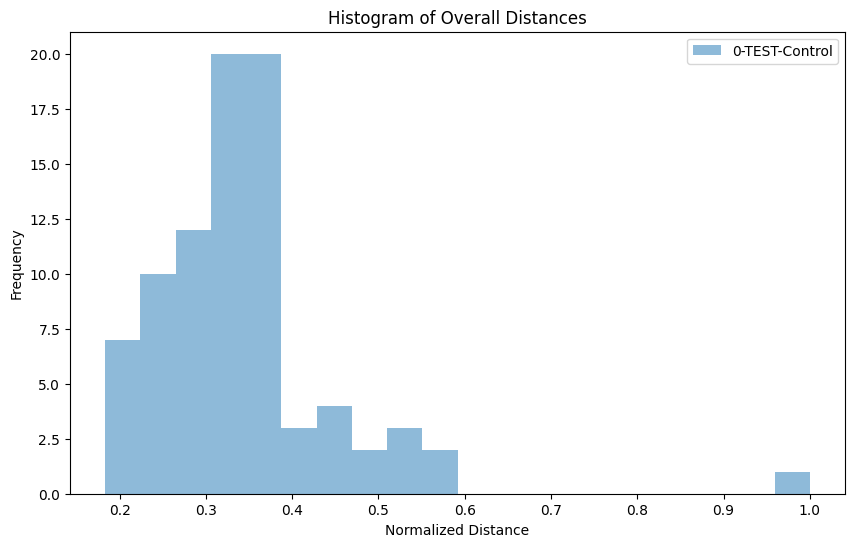

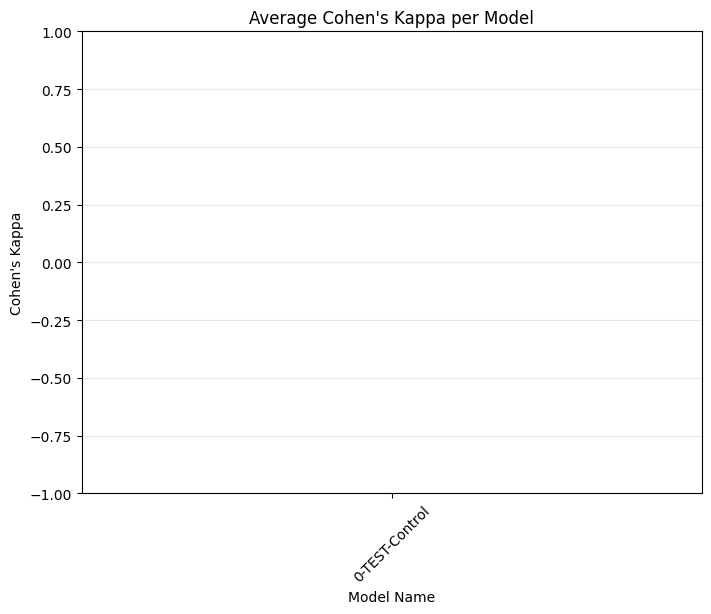

✅ Visualizations complete.


In [9]:
def run_evaluation():
    """
    Run through the previously-prepared tasks in PREPARED_TASKS, saving after every 5.
    Supports rate limiting when ENABLE_THROTTLING is True.
    """
    global GLOBAL_AI_EVAL_DF, GLOBAL_DISTANCES_DF, GLOBAL_KAPPA_DF, GLOBAL_HUMAN_EVAL_DF

    tasks = PREPARED_TASKS
    if not tasks:
        print("❌ No tasks to run. Please prepare tasks first.")
        return

    # Load human evaluations for distance and kappa
    GLOBAL_HUMAN_EVAL_DF = load_human_evaluations(
        TRANSCRIPTS_PATH,
        FRAMEWORK_PATH
    )

    all_records = []
    outdir = OUTDIR

    # Determine max workers based on throttling setting
    max_workers = MAX_WORKERS_THROTTLED if ENABLE_THROTTLING else MAX_WORKERS_NORMAL
    
    if ENABLE_THROTTLING:
        print(f"🐌 Rate limiting enabled: Using {max_workers} worker(s) with 3 API calls per minute limit")
        print(f"📊 Estimated time for {len(tasks)} tasks: {len(tasks) * 4 / 3:.1f} minutes")
        print("   (Each evaluation makes ~4 API calls: 4 domain batches )")
    else:
        print(f"🚀 Rate limiting disabled: Using {max_workers} workers for parallel execution")

    # Parallel execution with progress
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {}
        for row, model_name in PREPARED_TASKS:
            # Select the transcript text based on clip_number
            transcript_text = (
                row.get('First Audio Transcript Text', '')
                if row['clip_number'] == 'first'
                else row.get('Last Audio Transcript Text', '')
            )

            # Only supply an audio link for multimodal evaluators
            if 'MultiModal' in model_name:
                audio_file_path = (
                    row.get('First Audio Clip', '')
                    if row['clip_number'] == 'first'
                    else row.get('Last Audio Clip', '')
                ) or None
            else:
                audio_file_path = None

            # Schedule the evaluation call with throttling setting
            future = executor.submit(
                call_model,
                available_models[model_name],
                framework,
                transcript_text,
                audio_file_path,
                ENABLE_THROTTLING  # Pass throttling setting to call_model
            )
            futures[future] = (row, model_name)

        for i, future in enumerate(
            tqdm(as_completed(futures), total=len(futures), desc="Evaluating models"),
            start=1
        ):
            row, model_name = futures[future]
            print(f"✅ Task {i}/{len(futures)} → School_Clip={row['School_Clip']}, "
                  f"base_id={row['base_id']}, clip={row['clip_number']}, model={model_name}")
            try:
                eval_output = future.result()
            except Exception as e:
                error_msg = f"Exception in task {i}: {type(e).__name__}: {e}"
                print(f"❌ Error in task {i}/{len(futures)} → School_Clip={row['School_Clip']}, "
                      f"base_id={row['base_id']}, clip={row['clip_number']}, model={model_name}")
                print(f"🔍 DEBUG: {error_msg}")
                
                # Print the transcript length for debugging
                transcript_text = (
                    row.get('First Audio Transcript Text', '')
                    if row['clip_number'] == 'first'
                    else row.get('Last Audio Transcript Text', '')
                )
                print(f"🔍 DEBUG: Transcript length: {len(transcript_text)} chars")
                
                eval_output = {'domains': {}, 'summary': '', 'error': str(e)}

            # Flatten evaluator output
            flat = {
                'School_Clip': row['School_Clip'],
                'base_id': row['base_id'],
                'clip_number': row['clip_number'],
                'model_name': model_name
            }
            for domain in eval_output.get('domains', {}).values():
                for comp_id, comp_data in domain.get('components', {}).items():
                    for d in framework['structure']['domains']:
                        for c in d['components']:
                            if str(c['id']) == str(comp_id):
                                flat[c['name']] = comp_data.get('score')
            all_records.append(flat)

            # Progressive save every 5 tasks
            if i % 5 == 0 or i == len(futures):
                temp_df = pd.DataFrame(all_records)
                for m, grp in temp_df.groupby('model_name'):
                    fname = f"{outdir}/{m}_evaluations.csv"
                    grp.to_csv(fname, index=False)
                    print(f"✅ Intermediate save after {i} tasks for {m} → {fname}")

    # Final AI evaluations DataFrame
    GLOBAL_AI_EVAL_DF = pd.DataFrame(all_records)

    # Distances & Kappa computations
    distance_records = []
    kappa_records = []
    for _, row in GLOBAL_AI_EVAL_DF.iterrows():
        h_match = GLOBAL_HUMAN_EVAL_DF[
            (GLOBAL_HUMAN_EVAL_DF['base_id'] == row['base_id']) &
            (GLOBAL_HUMAN_EVAL_DF['clip_number'] == row['clip_number'])
        ]
        if not h_match.empty:
            domains, overall = compute_distances_for_item(h_match.iloc[0], row, framework)
            rec = {
                'base_id': row['base_id'],
                'clip_number': row['clip_number'],
                'model_name': row['model_name'],
                **{f"domain_{did}_dist": d for did, d in domains.items()},
                'overall_distance': overall
            }
            distance_records.append(rec)

    GLOBAL_DISTANCES_DF = pd.DataFrame(distance_records).set_index(['base_id', 'clip_number', 'model_name'])
    GLOBAL_DISTANCES_DF.to_csv(f"{outdir}/distance_metrics.csv")

    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            comp_id = str(comp['id'])
            comp_name = comp['name']
            score_list = comp.get('scoreList', ['Y', 'N', 'N/A'])
            for model_name in GLOBAL_AI_EVAL_DF['model_name'].unique():
                ai_ser = (
                    GLOBAL_AI_EVAL_DF[GLOBAL_AI_EVAL_DF['model_name'] == model_name][comp_name]
                    if comp_name in GLOBAL_AI_EVAL_DF else pd.Series()
                )
                human_ser = GLOBAL_HUMAN_EVAL_DF[comp_name]
                if len(human_ser) > 1 and not ai_ser.empty:
                    numeric_labels = all(str(lbl).isdigit() for lbl in score_list) and len(score_list) > 2
                    weight = 'quadratic' if any(lbl in ['L', 'M', 'H'] for lbl in score_list) or numeric_labels else None
                    try:
                        val = compute_component_kappa(human_ser, ai_ser, score_list, weight)
                    except Exception:
                        val = np.nan
                else:
                    val = np.nan
                kappa_records.append({
                    'component_id': comp_id,
                    'component_name': comp_name,
                    'model_name': model_name,
                    'kappa': val
                })

    GLOBAL_KAPPA_DF = pd.DataFrame(kappa_records)
    GLOBAL_KAPPA_DF.to_csv(f"{outdir}/kappa_results.csv", index=False)
    print(f"✅ Distance and kappa metrics saved under `{outdir}/`")

    # Visualize results by reading CSVs
    visualize_results()

# Call run_evaluation directly to see logs
print("Starting evaluation...")
run_evaluation()